<a href="https://colab.research.google.com/github/shengy90/MSc-Project/blob/master/notebooks/Online_Protocol_Exponentially_Weighted_Avg_of_Expert_Predictions_20200815.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1️⃣ Setup Notebook 💻**


### **Authenticate with BigQuery ☁️**

In [ ]:
!pip install --upgrade google-cloud-bigquery[bqstorage,pandas]
!pip install --upgrade pandas-gbq

In [ ]:
import google.auth
from google.colab import auth
from google.cloud import bigquery
from google.cloud import bigquery_storage_v1beta1

auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
credentials, your_project_id = google.auth.default(scopes=["https://www.googleapis.com/auth/cloud-platform"])
your_project_id = 'machine-learning-msc'
# Make clients.
bqclient = bigquery.Client(
    credentials=credentials,
    project=your_project_id
    )
bqstorageclient = bigquery_storage_v1beta1.BigQueryStorageClient(
    credentials=credentials
)

In [ ]:
query_string = """
SELECT
COUNT(*) AS test
FROM `machine-learning-msc.low_carbon_london.household_consumption_daily_agg` 
"""

In [ ]:
def download_query_results(query_string, bqclient=bqclient, bqstorateclient=bqstorageclient):
    df = bqclient.query(query_string).result().to_dataframe(bqstorage_client=bqstorageclient)
    return df

In [ ]:
df = download_query_results(query_string, bqclient, bqstorageclient)
df

,test
0,14841792


In [ ]:
import pandas_gbq
def output_to_bq(forecast, table_id, project_id='machine-learning-msc'):
    pandas_gbq.to_gbq(forecast, table_id, project_id=project_id, if_exists='append')

### **Importing Libraries⏬**

##### Standard Libraries

In [ ]:
!pip install fbprophet
!pip install MiniSom

  Created wheel for MiniSom: filename=MiniSom-2.2.6-cp36-none-any.whl size=8525 sha256=bb2ff42345eed220060425fc2f2afbbc4c0135b1dcf18db4d6d8768b4f74c81c
  Stored in directory: /root/.cache/pip/wheels/b8/c6/01/330066e36e1f7c826c96f656f9185822cfcdef0591315949ea
Successfully built MiniSom


In [ ]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
import random
import datetime as dt

from minisom import MiniSom
from tqdm.notebook import tqdm
from datetime import date
from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from matplotlib.gridspec import GridSpec
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
 
sns.set()
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import pandas_gbq
def output_to_bq(forecast, table_id, project_id='machine-learning-msc'):
    pandas_gbq.to_gbq(forecast, table_id, project_id=project_id, if_exists='append')

##### Import Github Repository

In [ ]:
%cd /content
!rm -rf mscproj
!git clone https://github.com/shengy90/MSc-Project mscproj
!git pull
%cd /content/mscproj/
!ls

/content
Cloning into 'mscproj'...
remote: Enumerating objects: 175, done.
remote: Counting objects: 100% (175/175), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 536 (delta 113), reused 108 (delta 56), pack-reused 361
Receiving objects: 100% (536/536), 12.81 MiB | 7.16 MiB/s, done.
Resolving deltas: 100% (311/311), done.
fatal: not a git repository (or any of the parent directories): .git
/content/mscproj
bin	     __init__.py  notebooks  requirements.txt  sql
definitions  Makefile	  README.md  run.py	       src


In [ ]:
%reload_ext autoreload 
%autoreload 2 
from src.train_prophet import TrainProphet
from src.train_clusters import TrainClusters
from src.train_clusters import Normaliser
from src.train_sliding_window import train_som, train_baseline, train_som_forecasts, evaluate_results, generate_query_strings

# 2️⃣ **Online Protocol - Exponentially Weighted Average of Expert Predidctions**

In [444]:
start_date = '2013-02-01'
query_string = f"""
    WITH stg1 AS (
        SELECT 
        DISTINCT
        *   
        FROM `machine-learning-msc.expert_predictions.results`
        WHERE start_date >= '{start_date}' AND start_date < '2013-06-01'
        AND train_test_split = 'test'
        )
    SELECT 
    *,
    ROW_NUMBER() OVER (
        PARTITION BY train_test_split, expert_name, CAST(cluster AS STRING)
        ORDER BY ds ASC) - 1 AS row_number
    FROM stg1
    ORDER BY train_test_split ASC, expert_name ASC, CAST(cluster AS STRING) ASC, ds ASC
    """
df = download_query_results(query_string)
df['ds'] = df['ds'].dt.tz_localize(None) # Remove Timezones
df_train = df.query("train_test_split=='train'").copy()
df_test = df.query("train_test_split=='test'").copy()

In [435]:
df_test['ds'].max()

Timestamp('2014-02-28 00:00:00')

In [495]:
def create_expert_df(df, idx_col):
    return df.groupby(idx_col).count().reset_index()[idx_col].copy()

def calculate_expert_prediction(df):
    idx_col = ['ds','row_number']
    expert_list = df['expert_name'].unique().tolist()
    df_expert_predictions = create_expert_df(df, idx_col)

    for expert in expert_list:
        df_expert = pd.DataFrame(df.query(f"expert_name=='{expert}'").groupby(idx_col)[['yhat_global']].sum()).reset_index()
        df_expert.rename(columns={'yhat_global':expert}, inplace=True)
        df_expert_predictions = df_expert_predictions.merge(df_expert, left_on=idx_col, right_on=idx_col)
    return df_expert_predictions

def get_outcomes(df):
    df_outcomes = df.groupby(['ds','row_number','expert_name'])['y_global'].sum().reset_index()
    df_outcomes = df_outcomes.groupby(['ds','row_number'])['y_global'].mean().reset_index()
    return df_outcomes 


def initialise_weights_df(in_df, expert_list):
    df = in_df.copy()
    df.set_index(['ds','row_number'])
    df[expert_list]=np.NaN
    df.reset_index(inplace=True)
    df.drop(columns='index', inplace=True)
    return df 

def normalise_weights(weights):
    total_sum = np.sum(weights)
    normalised_weights = weights/total_sum
    return normalised_weights

In [496]:
def _initiate_dataframes(df):
    expert_list = df['expert_name'].unique()

    # Data Frames
    df_experts = calculate_expert_prediction(df)
    df_outcomes = get_outcomes(df)
    df_weights = initialise_weights_df(df_experts, expert_list)
    df_norm_weights = df_weights.copy()
    df_expert_loss = df_weights.copy()
    df_learner = df_weights[['ds','row_number']].copy()
    df_learner['yhat_global'] = np.NaN 
    df_learner['learner_loss'] = np.NaN
    df_learner['y_global'] = np.NaN

    time_periods = df_weights['row_number']
    return expert_list, df_experts, df_outcomes, df_weights, df_norm_weights, df_expert_loss, df_learner, time_periods


def _evaluate_loss(outcome, pred):
    return np.power(np.log(outcome + 1) - np.log(pred + 1),2)

def _store_results(df, t, col, val):
    df.loc[df['row_number']==t, col] = val
    return df 

def _reset_weights(weights, normweights, limit):
    if np.any(weights < limit):
        fixed_weights = np.ones(len(weights)) * 0.1 # Resetting weights to 0.1
    else:
        fixed_weights = weights 
    return fixed_weights

def _update_weights_strategy(t, strategy_num, previous_weights, loss, eta):
    penalty = np.exp(-eta * loss)
    
    # STRATEGY 0
    if strategy_num == 0:
        updated_weights = previous_weights * (penalty)
        norm_weights = normalise_weights(updated_weights)

    # STRATEGY 1 
    elif strategy_num == 1:
        updated_weights = previous_weights * (0.1 + penalty)
        norm_weights = normalise_weights(updated_weights)

    # STRATEGY 2
    elif strategy_num == 2:
        ## initiate log
        if t == 1:
            updated_weights = np.log(previous_weights)
        else: 
            updated_weights = previous_weights + np.log(0.1 + penalty)
        norm_weights = normalise_weights(np.exp(updated_weights))
    
    # STRATEGY 3
    elif strategy_num == 3:
        if np.any(previous_weights < 0.000000001):
            print(f"⚠️ Replacing previous Weight at time {t}!")
            updated_weights = np.ones(len(previous_weights)) * 0.1 # reset to 0.1
        else:
            updated_weights = previous_weights * penalty
        norm_weights = normalise_weights(updated_weights)

    # STRATEGY 4
    elif strategy_num == 4:
        # Adding a constant to updated weights before normalising
        # So that in case weights become to small, they won't completely disappear 
        # And if all weights are equally small 
        updated_weights = previous_weights * (penalty) 
        norm_weights = normalise_weights(updated_weights + 0.0000001)

    else:
        raise ValueError(f"strategy_num {strategy_num} is invalid. It must be in [0, 1, 2, 3]")
    
    return updated_weights, norm_weights



def train_online(in_df, eta=1, strategy=0, verbose=False):
    df = in_df.copy()

    # Initialise Data Frames
    expert_list, df_experts, df_outcomes, df_weights, df_norm_weights, df_expert_loss, df_learner, time_periods = _initiate_dataframes(df)

    for t in tqdm(time_periods):
        # 1.1 If T = 0, W0 = 1/N where N = number of experts. Normalised W0 = W0 by definition.
        if t == 0:
            w0 = 1/len(expert_list)
            # w_e_t = np.log(w0) # All experts start off with an arbitrarily large weights to avoid weights decaying to ~ 0...
            w_e_t = w0
            p_e_t = w0
            w_t_prev = np.NaN
            loss_t_prev = np.NaN
        # 1.2 If T>0, W[t] = W[t-1] X np.exp(-0.5 * Loss[t-1]). Normalised W[n,t] = W[n,t-1]/W[t-1].
        else:
            t_prev = t - 1 

            # Get weights and losses from previous timestep
            w_t_prev = df_weights.loc[df_weights['row_number']==t_prev, expert_list].to_numpy()[0]
            loss_t_prev = df_expert_loss.loc[df_expert_loss['row_number']==t_prev, expert_list].to_numpy()[0]
            # Update and normalise weights            
            w_e_t, p_e_t = _update_weights_strategy(t, strategy, w_t_prev, loss_t_prev, eta)

        # 2. Get Expert predictions 
        gamma_e_t = df_experts.loc[df_experts['row_number']==t, expert_list].to_numpy()[0]

        # 3. Observe outcomes 
        omega_t = df_outcomes.loc[df_outcomes['row_number']==t, 'y_global'].to_numpy()[0]

        # 4. Calculate Expert Loss 
        loss_e_t = _evaluate_loss(omega_t, gamma_e_t)

        # 5. Calculate learner's prediction and learner's loss
        learner_t = np.sum(p_e_t * gamma_e_t)
        learner_loss_t = _evaluate_loss(omega_t, learner_t)
        
        if verbose==True:
            # Only print first 20 timesteps
            if t < 10:
                print(f"T = {t}.....................................")
                print(f"👁 Weights at previous timestep:\n{w_t_prev}")
                print(f"🏄 Losses at previous timestep:\n{loss_t_prev}")
                print(f"0️⃣ Weights:\n{w_e_t}")
                print(f"1️⃣ Normalised Expert Weights:\n{p_e_t}")
                print(f"2️⃣ Expert Predictions at T=t:\n{gamma_e_t}")
                print(f"3️⃣ Observe outcome at T=t:\n{omega_t}")
                print(f"4️⃣ Expert loss at T=t:\n{loss_e_t}")
                print(f"5️⃣ Learner's prediction and loss at T=t.\nPrediction: {learner_t}, Loss: {learner_loss_t}, MAPE: {np.round(np.abs(learner_t/omega_t-1)*100,4)}%")
                print("-------------------------------------------\n")

        # Store Results 
        df_weights.loc[df_weights['row_number']==t, expert_list] = w_e_t
        df_norm_weights.loc[df_norm_weights['row_number']==t, expert_list] = p_e_t
        df_expert_loss.loc[df_expert_loss['row_number']==t, expert_list] = loss_e_t
        df_learner.loc[df_learner['row_number']==t, 'yhat_global'] = learner_t 
        df_learner.loc[df_learner['row_number']==t, 'learner_loss'] = learner_loss_t
        df_learner.loc[df_learner['row_number']==t, 'y_global'] = omega_t
        df_learner['eta_value'] = str(eta)

    return df_experts, df_weights, df_norm_weights, df_expert_loss, df_learner

In [497]:
df_experts, df_weights, df_norm_weights, df_expert_loss, df_learner = train_online(df_test, strategy = 4, eta=1, verbose=False)

# **3️⃣ Analyse Results**

### **MAPE over all 13 months**

In [498]:
expert_list = df_test['expert_name'].unique()
df_learner_ape = df_learner.copy()
df_experts_ape = df_experts.copy() 


df_learner_ape['ape'] = np.round(np.abs(df_learner_ape['yhat_global']/df_learner_ape['y_global']-1),5)*100
df_experts_ape[expert_list] = np.round(np.abs(df_experts_ape[expert_list].divide(df_learner_ape['y_global'], axis=0)-1),5)*100

In [499]:
df_learner_ape['ape'].mean()

10.428802845528486

In [500]:
df_experts_ape[expert_list].mean()

expert_cluster_1      9.985421
expert_cluster_10    10.680274
expert_cluster_2     10.253032
expert_cluster_3      9.921957
expert_cluster_4     10.567411
expert_cluster_5     11.090817
expert_cluster_6     10.619285
expert_cluster_7     10.563929
expert_cluster_8     10.743144
expert_cluster_9     10.916622
dtype: float64

### **MAPE by calendar months**

In [501]:
def convert_ds_to_month(ds):
    return ds.strftime('%Y-%m')
df_learner_ape['calendar_month'] = df_learner_ape['ds'].apply(convert_ds_to_month)
df_experts_ape['calendar_month'] = df_experts_ape['ds'].apply(convert_ds_to_month)

In [502]:
df_learner_ape.groupby('calendar_month')['ape'].mean()

calendar_month
2013-05    18.980394
2013-06     7.864946
2013-07     8.615506
2013-08     6.171660
Name: ape, dtype: float64

In [503]:
res1 = pd.DataFrame(df_experts_ape.groupby('calendar_month')[['expert_cluster_1','expert_cluster_3','expert_cluster_5','expert_cluster_10']].mean())
res2 = pd.DataFrame(df_learner_ape.groupby('calendar_month')['ape'].mean())
res3 = res2.merge(res1, left_on='calendar_month', right_on='calendar_month')

In [504]:
res3

,ape,expert_cluster_1,expert_cluster_3,expert_cluster_5,expert_cluster_10
calendar_month,,,,,
2013-05,18.980394,17.532736,17.277273,20.723355,19.815033
2013-06,7.864946,7.837611,7.913185,7.809419,7.850637
2013-07,8.615506,8.492555,8.301265,9.473524,8.804522
2013-08,6.171660,6.009498,6.131308,6.251118,6.159627


### **Plot Experts normalised weights over time**

In [505]:
def unpivot_df(df, expert_list, var_name):
    out_df = pd.DataFrame()
    for expert in expert_list:
        expert_df = df[['ds','row_number',expert]].copy()
        expert_df.rename(columns={expert: var_name}, inplace=True)
        expert_df['expert_name'] = expert
        out_df = pd.concat([out_df, expert_df])
    return out_df

df_norm_weights_unpivot = unpivot_df(df_norm_weights, expert_list, var_name="normalised_weights")

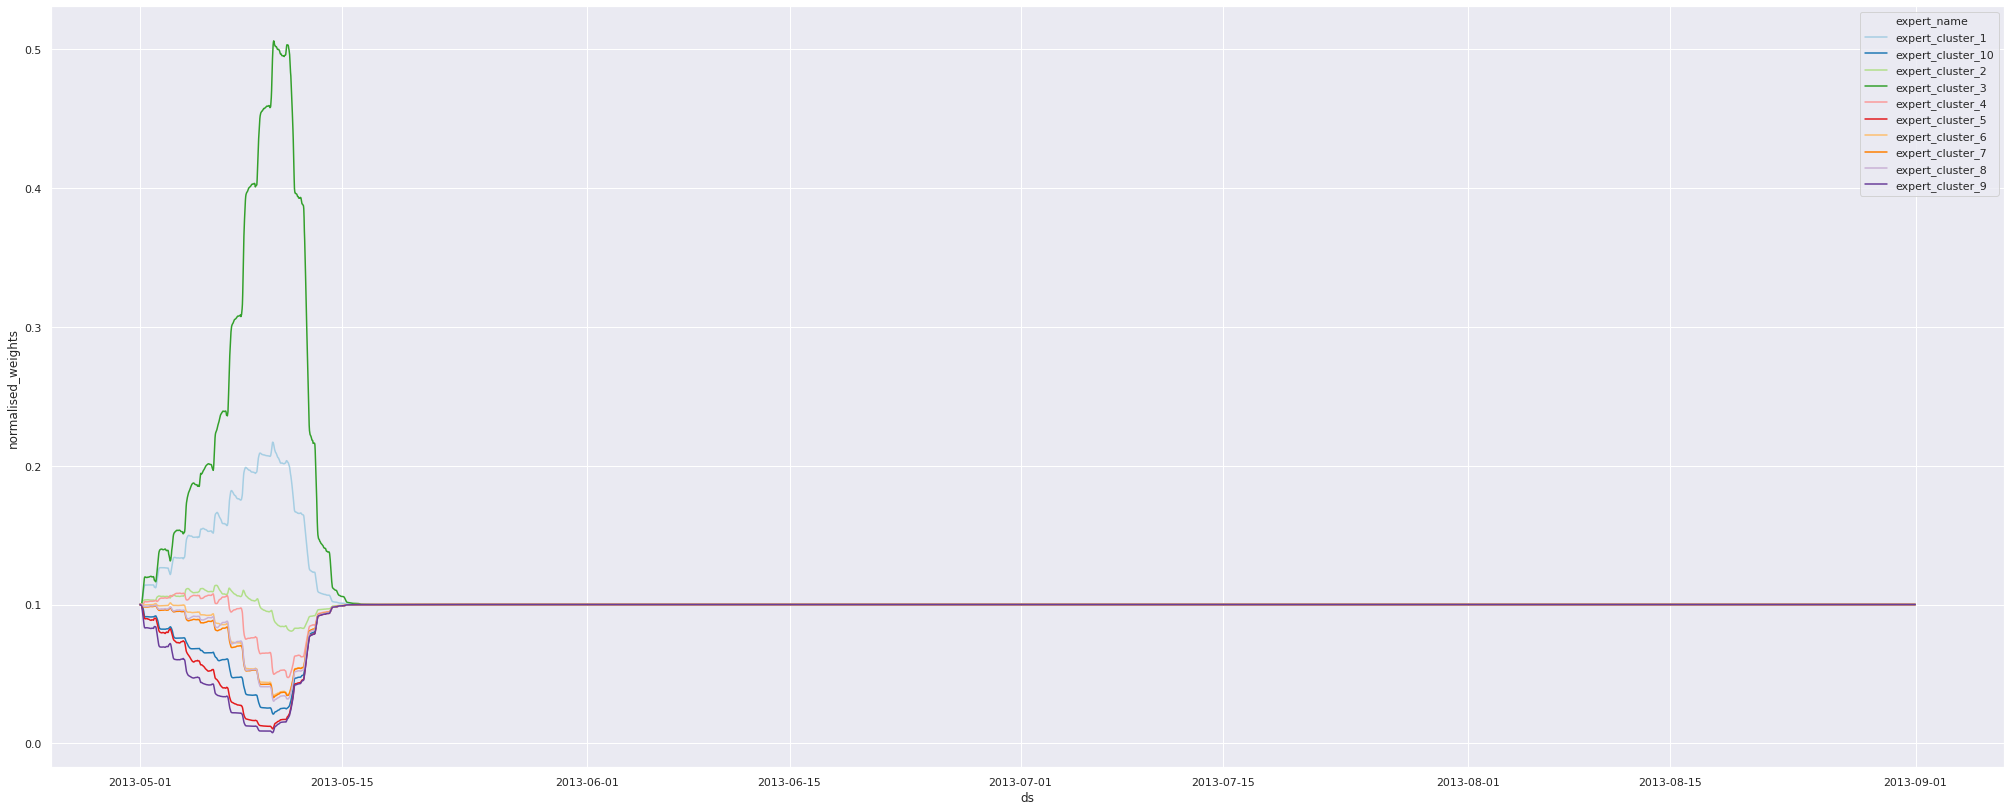

In [506]:
sns.set_palette("Paired")
fig = plt.figure(figsize=(35,14))
sns.lineplot(x='ds', y='normalised_weights', hue='expert_name', data=df_norm_weights_unpivot)

In [507]:
df_norm_weights_unpivot['normalised_weights'].max(), df_norm_weights_unpivot['normalised_weights'].min()

(0.5060946823693855, 0.007655237896276974)

In [477]:
df_weights.head(100)

,ds,row_number,expert_cluster_1,expert_cluster_10,expert_cluster_2,expert_cluster_3,expert_cluster_4,expert_cluster_5,expert_cluster_6,expert_cluster_7,expert_cluster_8,expert_cluster_9
0,2013-05-01 00:00:00,0,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
1,2013-05-01 00:30:00,1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
2,2013-05-01 01:00:00,2,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
3,2013-05-01 01:30:00,3,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
4,2013-05-01 02:00:00,4,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...
95,2013-05-02 23:30:00,95,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
96,2013-05-03 00:00:00,96,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
97,2013-05-03 00:30:00,97,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
98,2013-05-03 01:00:00,98,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
